# **Integrated Gradients: Практика**

Добро пожаловать на практику по методу интегрированные градиенты! По счету  методов объяснения для глубинных моделей — это наша пятая практика :)
Поздраввляю, вы проделали большой путь!

И так, вся тетрадь посвящена методу **Integrated Gradients** — первому axioms-based методу в нашем курсе. Напомню, аксиом всего 5, а формула вычисления для Integrated Gradients есть:
![ig_image](https://ucarecdn.com/9e86fa78-8c24-4b69-8743-1e9484caa629/)

В этом уроке вы:
- Реализуете метод Integrated Gradients с 0 в виде пользовательской функции;
- Попрактикуесь в применении метода из библиотеки CAPTUM — библиотеки, посвященной Interpretability для PyTorch-моделей;
- Прочувствуете разницу использования различных baselines для метода;

Будет интересно!
 Приятного кодинга!

Прежде, установим библиотеку captum. Она понадобится нам в конце занятия.

In [ ]:
!pip install captum -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 20.7 MB/s eta 0:00:00


И импортируем всё, что нужно для работы.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import requests
from datetime import datetime
from tqdm import tqdm
from io import BytesIO
import urllib
from PIL import Image
%matplotlib inline

import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

from torchvision import models

from captum.attr import IntegratedGradients
from captum.attr import visualization as viz

from torchvision.models import resnet50, swin_t

Работать, как и напервых практиках будем с предобученными сетями. Однако, чтобы не создавать иллюзию, что объяснять можно только сверточные нейронные сети, в этот раз поработаем ещё и с моделью типа трансформер — `SWIN`. Обзор на архитектуру вы можете найти [здесь](https://habr.com/ru/articles/599057/).

In [ ]:
resnet = resnet50(weights='IMAGENET1K_V1') # как и раньше, используем ResNet
swin_net = swin_t(weights='IMAGENET1K_V1') # и подгрузим Swin'a

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 124MB/s]
Downloading: "https://download.pytorch.org/models/swin_t-704ceda3.pth" to /root/.cache/torch/hub/checkpoints/swin_t-704ceda3.pth
100%|██████████| 108M/108M [00:01<00:00, 78.3MB/s]


Работать будем с двумя изображениями. Первым нашим примером будет хрюшка, а вторым — котик.

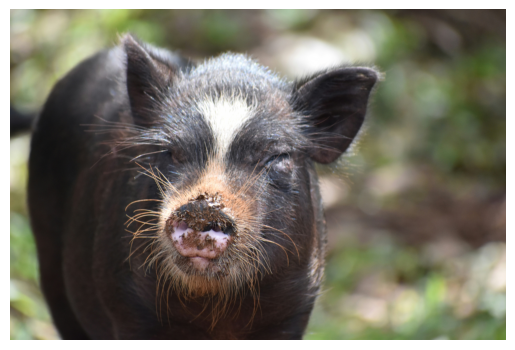

In [ ]:
hog_url = 'https://github.com/SadSabrina/explainable_AI_course/blob/main/HW_module10.2_gradient_methods/hog.jpg?raw=true'

hog_image_bytes = requests.get(hog_url).content
hog_image = Image.open(BytesIO(hog_image_bytes))

plt.axis('off')
plt.imshow(hog_image);

1. Котика загрузите и визуализируйте самостоятельно, используя ссылку: https://github.com/aiedu-courses/all_datasets/blob/main/images/cat.jpg?raw=true

In [ ]:
cat_url = 'https://github.com/aiedu-courses/all_datasets/blob/main/images/cat.jpg?raw=true'

cat_image_bytes = # Ваш код здесь
cat_image = # Ваш код здесь

plt.axis('off')
plt.imshow(cat_image);

Также нам дополнительно понадобятся класы и индексы из Imagenet, чтобы верифицировать прогнозы сетей.

In [ ]:
url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
urllib.request.urlretrieve(url, "imagenet_classes.txt")

with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]

Проделаем стандартные шаги — предобработаем изображения перед подачей моделям при помощи функции transfrom.

In [ ]:
#Средние
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Выполним предобработку изображения
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)), # Изменение размера изображения
    torchvision.transforms.ToTensor(),          # Преобразование в тензор
    torchvision.transforms.Normalize(mean, std) # Нормализация
])

In [ ]:
hog_input = transform(hog_image) # предобработаем изоабражения
cat_input = transform(cat_image)

fig, ax = plt.subplots(1, 2, figsize=(12, 8))

ax[0].imshow(hog_input.permute((1, 2, 0))) ; # посмотрим, что получилось после нормализации для хрюши
ax[0].set_title('Hog after transform')

ax[1].imshow(cat_input.permute((1, 2, 0))) # и для котика
ax[1].set_title('Cat after transform');

В завершение для обоих изображений добавим размерность батча и явно укажем pyTorch рассчитать и сохранить градиенты для них.

In [ ]:
hog_input.unsqueeze_(0);  # добавим размерность батча
cat_input.unsqueeze_(0);

hog_input.requires_grad = True  # явно указываем PyTorch рассчитать и сохранить градиенты для входного изображения
cat_input.requires_grad = True

2. Получите прогноз для моделей. Какие индексы спрогнозировали resnet, swin? Занесите ответы на степик в вопросы 1, 2, 3.

Целевыми будем считать классы hog (341) и tiger cat (282).

In [ ]:
cat_resnet_index = # Ваш код здесь
cat_swin_index = # Ваш код здесь

print(f'ResNet prediction for cat {cat_resnet_index} (index), {categories[cat_resnet_index]} (class)')
print(f'SwinNet prediction for cat {cat_swin_index} (index), {categories[cat_swin_index]} (class)')

In [ ]:
hog_resnet_index = # Ваш код здесь
hog_swin_index = # Ваш код здесь

print(f'ResNet prediction for hog {hog_resnet_index} (index), {categories[hog_resnet_index]} (class)')
print(f'SwinNet prediction for hog {hog_swin_index} (index), {categories[hog_swin_index]} (class)')

Как видим, модель SWIN очень неожиданно подошла к решению поставленной задачи! Посмотрим какие классы вошли в топ-3 для кота и что же смутило SWIN'а.

3. Получите топ-3 прогнозы Swin Transformer для класса cat. На сколько первый индекс больше, чем второй? Полученное значение укажите в шаг 5 до 4-го знака после запятой.

In [ ]:
top3_swin_cat = # Ваш код здесь

print('Top3 Swin for cat image: ', top3_swin_cat[:])

Расшифруйте прогноз swin transformer для 2го значения и 3-го значений.

Считать то, что целевой класс не попал в топ-3 для модели swin ошибкой или нет зависит от задачи. Например, если бы мы распознавали именно породы кошек, то модель явно ещё предстоит дообучать или придумывать что-то другое.

Давайте посмотрим, что заставило модель включить в топ-3 неодушевленные предметы, используя Integrated Gradients.

**1. Integrated gradients: пользовательская реализация.**

Прежде чем писать сам метод, подготовим объекты, которые будем считать *базовыми*. Как мы отметили в теории, выходы метода (то есть, наши объяснения) будут чувсительны к разным baselines. Пришло время проверить это на практике!

**Среди объектов-кандитатов в базовые рассмотрим 4:**
-  Полностью нулевое изображение (zero baseline)
- Изображение на основе Гауссовского шума (noise baseline)
- Изображение на основе среднего по каналам (mean baseline)
- Изображение на основе случайного распределения (random baseline)

Можно рассматривать и другие. Общая рекомендация такая — часто хорошо срабатывает zero-baseline, но иногда использование других позволяет уточнить некоторые области. Лучше рассматривать несколько, включая zero baseline.

In [ ]:
def gaussian_noise(x, var):
  """
  Гауссовский шум на основе изображения x
  """

  return torch.normal(0, var, size=x.shape)


def random_baseline(x, low, high):
    """
    Cлучайное распределение на основе изображения x
    """

    return np.random.uniform(low, high,x.shape)



Последовательно реализуем и визуализируем 4 базовых объекта для изображения с котиком, поскольку будем исследовать только прогнозы на данном объекте.

In [ ]:
cat_zero_baseline = cat_input * 0 #Zero baseline


cat_noise_baseline = torch.ones_like(cat_input) # Noise baseline
cat_noise_baseline += gaussian_noise(cat_noise_baseline, 0.1)

cat_mean_baseline = torch.ones_like(cat_input) # Mean baseline
cat_mean_baseline *= torch.mean(cat_input, axis=1)

cat_random_baseline = random_baseline(x=cat_input, low=0, high=15) # Random baseline
cat_random_baseline = torch.from_numpy(cat_random_baseline).float()


И напишем простую функцию для визуализации тензоров, чтобы автоматизировать этот процесс.

In [ ]:
def vizualize_tensor(tensor):

  if len(tensor.shape) == 4:
    return tensor.squeeze(0).permute((1, 2, 0)).detach().numpy()
  else:
    return tensor.permute((1, 2, 0)).detach().numpy()

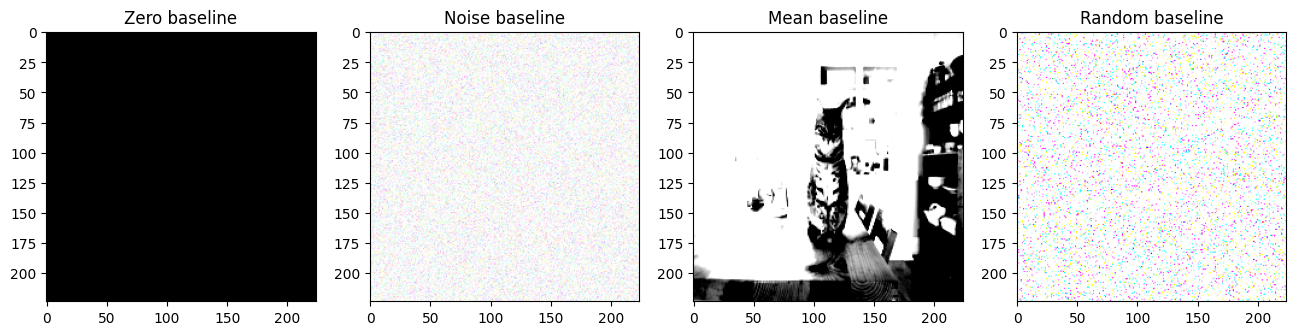

In [ ]:
# Создание фигуры и сетки 1x4
fig, axes = plt.subplots(1, 4, figsize=(16, 8))

# Отображение каждого изображения строка 1
axes[0].imshow(vizualize_tensor(cat_zero_baseline))
axes[0].set_title('Zero baseline')

axes[1].imshow(vizualize_tensor(cat_noise_baseline))
axes[1].set_title('Noise baseline')

axes[2].imshow(vizualize_tensor(cat_mean_baseline))
axes[2].set_title('Mean baseline')

axes[3].imshow(vizualize_tensor(cat_random_baseline))
axes[3].set_title('Random baseline');

Теперь пришло время реализовать Integrated gradients. Нужная нам формула:
![ig_image](https://ucarecdn.com/9e86fa78-8c24-4b69-8743-1e9484caa629/)

Нам необходимо:
1. Получать объекты x и baselines для них
2. Считать дифференциал в виде взвешенной суммы

Реализуйте вычисление суммы. В качестве аргумента X вам необходимо добавить значение **внутри** функции, то есть $(x' + \frac{k}{m}(x-x'))$

In [ ]:
from tqdm import tqdm


def compute_integrated_gradient(batch_x, batch_blank, model, index_interested, m=100):

    mean_grad = 0

    baseline_diff = (batch_x - batch_blank)/m # первые два множителя

    for i in tqdm(range(1, m + 1)):

        x =  """ Ваш код здесь """ # значение, которое будет подано функции в числителе
        x.requires_grad_ = True                           # явно указываем pyTorch считать градиенты
        y = model(x)                                      # получаем прогноз модели

        score = y[0, index_interested]                    # считаем градиент по интересующему нас признаку
        (grad,) = torch.autograd.grad(score, x)
        mean_grad += grad                                 # добавляем с переменную слагаемое УЖЕ деленное на количество шагов аппроксимации

    mean_grad /= m


    integrated_gradients = (batch_x - batch_blank) * mean_grad # собираем все множители

    return integrated_gradients

Данное задание тестирует правильность реализации строки выше. В ответ на степик укажите значение, выданное print, при `m = 10`.

In [ ]:
def test_compute_x():
    batch_x = torch.ones((1, 3, 224, 224)) * 255
    batch_blank = torch.zeros((1, 3, 224, 224))
    m = 10

    #
    expected_x = batch_blank + 5 / 10 * (batch_x - batch_blank)

    #
    computed_x = None
    for j in range(1, 5 + 1):
        computed_x = batch_blank + j / m * (batch_x - batch_blank)

    assert torch.allclose(computed_x, expected_x), "Ошибка в вычислении переменной x"
    print(computed_x[0, 0, 0, 0])

test_compute_x()


In [ ]:
categories[532], categories[285], categories[495]

('dining table', 'Egyptian cat', 'china cabinet')

И так, посмотрим, что заставило модель включить в топ-3 два неодушевленных предмета с индексами 532 и 495, используя построенную функцию.

In [ ]:
cat_ig_zero532 = compute_integrated_gradient(cat_input, cat_zero_baseline, swin_net, 532, 50)
cat_ig_noise532  = compute_integrated_gradient(cat_input, cat_noise_baseline, swin_net, 532, 50)
cat_ig_mean532 = compute_integrated_gradient(cat_input, cat_mean_baseline, swin_net, 532, 50)
cat_ig_random532  = compute_integrated_gradient(cat_input, cat_random_baseline.float(), swin_net, 532, 50)

100%|██████████| 50/50 [00:27<00:00,  1.81it/s]


Посмотрим, какие карты получились для индекса 532.

In [ ]:
# CAT + SWIN NET

# Создание фигуры и сетки 2x4
fig, axes = plt.subplots(2, 4, figsize=(12, 6))

# Отображение каждого изображения строка 1
# Отображение каждого изображения строка 1
axes[0, 0].imshow(vizualize_tensor(cat_zero_baseline))
axes[0, 0].set_title('Zero baseline')

axes[0, 1].imshow(vizualize_tensor(cat_noise_baseline))
axes[0, 1].set_title('Noise baseline')

axes[0, 2].imshow(vizualize_tensor(cat_mean_baseline))
axes[0, 2].set_title('Mean baseline')

axes[0, 3].imshow(vizualize_tensor(cat_random_baseline))
axes[0, 3].set_title('Random baseline');


# Отображение каждого изображения строка 2
axes[1, 0].imshow(vizualize_tensor(cat_ig_zero532)*10)
axes[1, 0].set_title('Zero ig')

axes[1, 1].imshow(vizualize_tensor(cat_ig_noise532)*10)
axes[1, 1].set_title('Noise ig')

axes[1, 2].imshow(vizualize_tensor(cat_ig_mean532)*10)
axes[1, 2].set_title('Mean ig')

axes[1, 3].imshow(vizualize_tensor(cat_ig_random532)*10)
axes[1, 3].set_title('Random ig')


# Отключение осей для всех изображений
for ax in axes.flat:
    ax.axis('off')

# Отображение изображений
plt.tight_layout()
plt.show();

И посмотрим, какие карты получились для индекса 495.

In [ ]:
swin_net.zero_grad()

cat_ig_zero495 = compute_integrated_gradient(cat_input, cat_zero_baseline, swin_net, 495, 50)
cat_ig_noise495 = compute_integrated_gradient(cat_input, cat_noise_baseline, swin_net, 495, 50)
cat_ig_mean495  = compute_integrated_gradient(cat_input, cat_mean_baseline, swin_net, 495, 50)
cat_ig_random495 = compute_integrated_gradient(cat_input, cat_random_baseline.float(), swin_net, 495, 50)

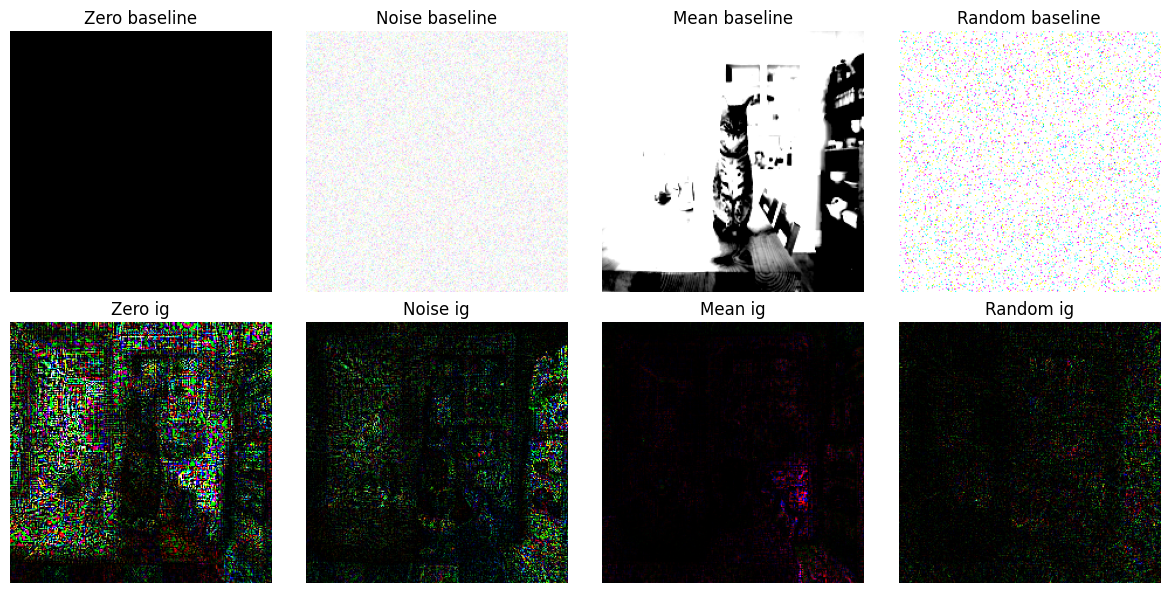

In [ ]:
# CAT + SWIN NET

# Создание фигуры и сетки 2x4
fig, axes = plt.subplots(2, 4, figsize=(12, 6))

# Отображение каждого изображения строка 1
# Отображение каждого изображения строка 1
axes[0, 0].imshow(vizualize_tensor(cat_zero_baseline))
axes[0, 0].set_title('Zero baseline')

axes[0, 1].imshow(vizualize_tensor(cat_noise_baseline))
axes[0, 1].set_title('Noise baseline')

axes[0, 2].imshow(vizualize_tensor(cat_mean_baseline))
axes[0, 2].set_title('Mean baseline')

axes[0, 3].imshow(vizualize_tensor(cat_random_baseline))
axes[0, 3].set_title('Random baseline');


# Отображение каждого изображения строка 2
axes[1, 0].imshow(vizualize_tensor(cat_ig_zero495)*10)
axes[1, 0].set_title('Zero ig')

axes[1, 1].imshow(vizualize_tensor(cat_ig_noise495)*10)
axes[1, 1].set_title('Noise ig')

axes[1, 2].imshow(vizualize_tensor(cat_ig_mean495)*10)
axes[1, 2].set_title('Mean ig')

axes[1, 3].imshow(vizualize_tensor(cat_ig_random495)*10)
axes[1, 3].set_title('Random ig')


# Отключение осей для всех изображений
for ax in axes.flat:
    ax.axis('off')

# Отображение изображений
plt.tight_layout()
plt.show();

Видно, что модель обращает внимание на *обстановку комнаты*, а не на центральный объект. В реальной задаче одним из возможных решений могла бы быть валидация входных изображений по правилу (например) "если объект занимает маленькое место на картинке, то обрезать изображение".

Посмотрим, действительно ли сработает обрезка изображения!

Подберите необходимое `crop_value`

In [ ]:
width, height = cat_image.size

crop_value = # Ваш код здесь

left = (width - crop_value)/2
top = (height - crop_value)/2
right = (width + crop_value)/2
bottom = (height + crop_value)/2

cropped_cat = cat_image.crop((left, top, right, bottom))

cropped_cat_input = transform(cropped_cat)

fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(vizualize_tensor(cropped_cat_input))

In [ ]:
cropped_cat_input.unsqueeze_(0);  # добавим размерность батча

cropped_cat_input.requires_grad = True  # явно указываем PyTorch рассчитать и сохранить градиенты для входного изображения

In [ ]:
print('Прогноз модели для cropped изображения:', categories[int(torch.argmax(swin_net(cropped_cat_input)))])

Прогноз модели для cropped изображения: Egyptian cat


In [ ]:
torch.topk(swin_net(cropped_cat_input), axis=1, k=3)

torch.return_types.topk(
values=tensor([[8.4859, 6.9463, 6.3264]], grad_fn=<TopkBackward0>),
indices=tensor([[285, 281, 282]]))

Нужная обрезка не только поможет модели распознать кошку, но и выкинет все неодушевленные предметы из топ3!

**2. Integrated gradients: работа с библиотекой captum.**

Напоследок, попрактикуемся с использованием библиотеки.

Для работы с методом Integrated gradients, вам понадобится сам IntegratedGradients (его мы уже импортировали в первой ячейке) и метод .attribute.



```
attribute(inputs, baselines=None, target=None, additional_forward_args=None,
n_steps=50, method='gausslegendre', internal_batch_size=None, return_convergence_delta=False)

```
где:
- inputs — входные изображения
- baselines - baselines изображений
- target — класс, по которому будет строится объяснение
- additional_forward_args — в случае если модель возвращает не только стандартный output, но и другие объекты Python
- n_steps - количество шагов аппроксимации
- method — метод вычисления интеграла
- internal_batch_size — для разбиения inputs, если требуется
- return_convergence_delta — разница между общими приближенными и истинными интегрированными градиентами


Реализуем вычисление и измерим время.

In [ ]:
start_time = datetime.now()

integrated_gradients = IntegratedGradients(swin_net)
swin_net.zero_grad()
captum_ig_attributions = integrated_gradients.attribute(inputs=cat_input,
                                                        baselines=cat_zero_baseline,
                                                        target=532,
                                                        n_steps=50,
                                                        method='riemann_right')

print(f'Duration: {datetime.now() - start_time}')


Duration: 0:00:38.378437


И, конечно, визуализируем результат!

In [ ]:
plt.imshow(vizualize_tensor(captum_ig_attributions)*10)

# **Заключение**

И так, в этом уроке вы:
- Реализовали метод Integrated Gradients с 0
- Поработали с различными baselines для метода Integrated Gradients
- Решили проблему определения некорретного класса моделью Swin Transformer
- Познакомились с библиотекой captum.

Также важно отметить, что в нашем примере и нашей практике для изображения с котом важные зоны лучше всего были показаны при нулевом бейзлайне. **Но это не значит, что zero baseline всегда ведет к успеху!** Подбирать baseline необходимо к каждому конкретному изображению самостоятельно. Кроме того, вы наверное заметили, что по умолчанию мы умножали карты на 10, без объяснений этого действия. Это связано с тем, что получаемые значения могут быть **очень маленькими** и вместо важны зон вы увидите просто черный квадрат. Другой способ работы с этим — использовать возможности captum, которые мы обсудим в следующей практике.

![photo_2024-08-17_13-20-47.md.jpg](https://ltdfoto.ru/images/2024/08/17/photo_2024-08-17_13-20-47.md.jpg)

